# Topic Modelling Community Cluster Detection and sentiment Analysis

# Objective

Topic modelling takes a single text or corpus and looks for patterns in the use of words, it is an attempt to inject semantic meaning to vocabulary. It assumes that any piece of text is composed by selecting words from possible baskets of words where each basket corresponds to a topic. The process iterates multiple times till it has the most likely distribution of words into baskets which are named as topics.The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. We have tried to implement 2 variants of Latent Dirichlet Allocation(LDA) as it is a popular algorithm for topic modeling for small documents like tweets.


In the next step we calculate the cosine similarity of the documents to know the overlap in the topics and the similarity in the opinions of different people. We cluster them to form communities so that we can group people based on their similar opinions. We use infomap to detect community clusters as unlike LPA which we used in retweet networks, infomap correctly segragates clusters even when there is overlap in the clusters. 

Finally we calculate the sentiments of each clusters based on weighted average of the sentiments of tweets and the collection of hashtags used for the tweets. The sentiments of tweets are calculated using textblob and the sentiments of hashtags are calculated using leepy belief algorithm. The implementation of LBP is done in a separate jupyter notebook in this folder and the output is being read directly from the file generated by the algorithm. This way we get better sentiment accuracy for the clusters.

## Import necessary modules

In [43]:
import pandas as pd
import functools
import re
import numpy as np

from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from nltk.util import ngrams
from nltk import FreqDist
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', -1)


## Read and Preprocess data

We use Humans.csv as the input file for this analysis which was generated after discarding the fake accounts and cleaning the tweets with standard NLP techniques. Thus this file comprises of cleaned tweets from accounts that are not fake. We read the required columns from this file as a pandas dataframe and apply the following preprocessing steps:
* *Drop any column that has missing values*
* *Filter out the retweets since they are textually same as the original tweets.*
* *Filter out records if they are NAN*
* *Merge records by users*
* *Remove # from hashtags and convert to lower case*
* *Remove punctuations and tokennize the tweets*

In [2]:
# check NAN
def isNaN(num):
    return num != num

In [3]:
# Read data
read_df = pd.read_csv("../humans.csv", sep = ';', index_col=None, usecols = ['screen_name', 'hashtags', 'lemma_filter','retweets_count'])

# Preprocess Data
df = read_df.reset_index().dropna()
df = df[df['retweets_count'] == 0]
df = df[df.apply(lambda x: (isNaN(x['lemma_filter'])==False) and (isNaN(x['screen_name'])==False), axis=1)]

# Merge tweets and hashtags by user and clean hashtags
temp0 = df.groupby('screen_name').size().reset_index(name='counts')
temp1 = df.groupby('screen_name')['lemma_filter'].apply(' '.join).reset_index()
temp2 = df.groupby('screen_name')['hashtags'].apply(','.join).reset_index()
data_frames = [temp0,temp1,temp2]
tweets = functools.reduce(lambda  left,right: pd.merge(left,right,on=['screen_name'], how='inner'), data_frames)
tweets['hashtags_list'] = tweets.apply(lambda x: [i for i in set(re.findall(r"[\w']+", x['hashtags'].lower())) if len(i) > 1], axis=1)
tweets = tweets[['screen_name', 'lemma_filter', 'hashtags_list']].reset_index()
tweets['index'] = tweets.index

#print the first two cleaned records
tweets.head(2)


,index,screen_name,lemma_filter,hashtags_list
0,0,0.bts.officials.0,—————————————————————————— wish lucky 🍀 —————————————————————————— • • • • 🥀🍀🥀 • • • • • • 🥀🍀🥀,"[teahung, bangtanboys, cute, girl, lucky, inlove, metoo, bts, love, korea, sweet]"
1,1,0.gin.ger.0,"🌻 •love ! -so give u right attack purposefully sag pant well , right ?","[nomeansno, thisisnotconsent, metoo, consentissexy, nomeansnoworldwide]"


In [7]:
# Remove punctuations and tokennize the tweets
def token_words(sentence):
    return [i for i in (simple_preprocess(str(sentence), deacc=True))]

tweets['processed_lemma_filter'] = tweets.apply(lambda x: token_words(x['lemma_filter']), axis=1)
data = tweets['processed_lemma_filter'].values

## Check the most frequent words being used

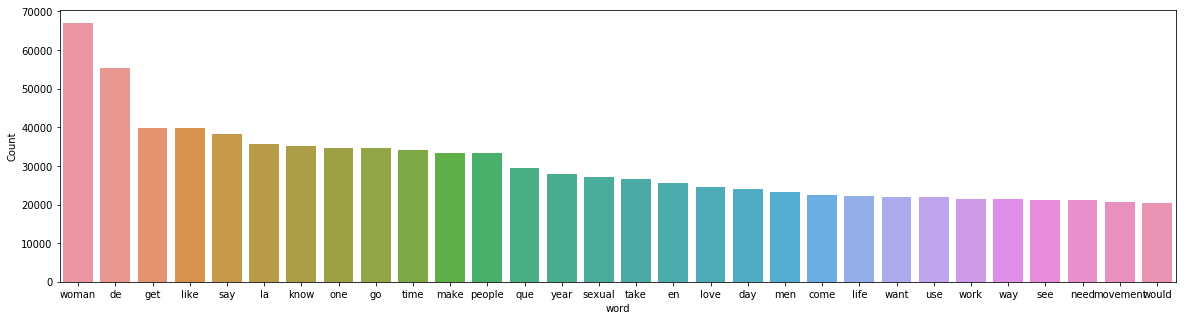

In [5]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

vis_data = []
for i in range(len(data)):
    vis_data.append(' '.join(data[i]))

freq_words(vis_data)

## Prepare the corpus for LDA and apply Frequency Filter

The two main inputs the topic model are the dictionary(id2word) and the corpus. We filter out very frequent or very rare words as we find in the above diagram that the choise of words are not great.

In [8]:
#Build a Dictionary(associate word to numeric id)
id2word = corpora.Dictionary(data)

# ignore words that appear in less than 20 documents or more than 10% documents
id2word.filter_extremes(no_below=20, no_above=0.1)
# print(id2word)

#Preparing Document-Term Matrix(word_id to word_freq)
corpus = [id2word.doc2bow(text) for text in data]
print("the corpus for the 20th tweet")
print(corpus[0])
print("the words of the 20th tweet with the freq")
# [(id2word[i[0]],i[1]) for i in corpus[0]] ##print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]])


the corpus for the 20th tweet
[(0, 1), (1, 1)]
the words of the 20th tweet with the freq


## Build Topic Model with optimal number of topics

We build the LDA model with gensim library. We train two variants of LDA, the basic version which is probabilistic topic modelling and the MalletLDA which is implementation of Gibbs sampling In order to get the optimal number of topics we build many LDA models with different number of topics and choose the one with the highest accuracy. Accuracy is measured by coherence score. Higher the score, better the model.

In [12]:
# function to get optimal number of topics LDA
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    model_list = []
    coherence_values = []
    
    for num_topics in range(start, limit, step):
        lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=500, passes=10,
                                            alpha='auto', per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

LDAmodel_list, coherence_values_lda = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=20, step=6)

print("coherence score of LDA model")
print(coherence_values_lda)

coherence score of LDA model
[0.5520639938136651, 0.507294872215525, 0.4740843644283462]


#### Please Note: Mallet model often gives a better result but takes a very long time to train. Because of this we perform the rest of the analysis from next section onwards with basic LDA. However to see the performance of the models "Please download the the zip file, unzip it and give proper path to execute the below subsections pertaining to Mallet LDA"

In [14]:
# Mallet’s version, however, often gives a better quality of topics.
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip 
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet_new/mallet-2.0.8/'}) # change the path as required
mallet_path = 'C:\\mallet_new\\mallet-2.0.8\\bin\\mallet' # change the path as required

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    Mallet_coherence_values = []
    Malletmodel_list = []
    
    for num_topics in range(start, limit, step):
        Malletmodel = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        Malletmodel_list.append(Malletmodel)
        coherencemodel = CoherenceModel(model=Malletmodel, texts=texts, dictionary=dictionary, coherence='c_v')
        Mallet_coherence_values.append(coherencemodel.get_coherence())
        
    return Malletmodel_list, Mallet_coherence_values

Malletmodel_list, Mallet_coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=20, step=6)

print("coherence score of MalletLDA model")
print(Mallet_coherence_values)

coherence score of MalletLDA model
[0.34909725335163844, 0.635553800712542, 0.6283341502461341]


#### Thus we see that Mallet model performs way better than LDA. Lets visualize it through graph and find the optimal number of topics.

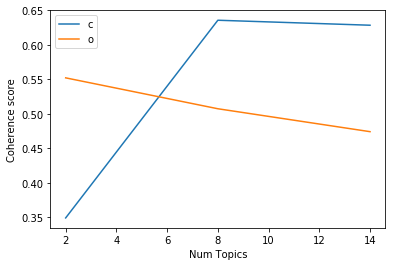

Num Topics Mallet = 2  has Coherence Value of 0.3491
Num Topics Mallet = 8  has Coherence Value of 0.6356
Num Topics Mallet = 14  has Coherence Value of 0.6283


Num Topics LDA = 2  has Coherence Value of 0.5521
Num Topics LDA = 8  has Coherence Value of 0.5073
Num Topics LDA = 14  has Coherence Value of 0.4741


In [30]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, Mallet_coherence_values)
plt.plot(x, coherence_values_lda)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Print the coherence scores
for m, cv in zip(x, Mallet_coherence_values):
    print("Num Topics Mallet =", m, " has Coherence Value of", round(cv, 4))
print('\n')
for m, cv in zip(x, coherence_values_lda):
    print("Num Topics LDA =", m, " has Coherence Value of", round(cv, 4))

#### Thus the optimal number of topics for Mallet_LDA is 8 with highest coherence score of 0.63 and for LDA its 2 topics with highest score of 0.55.

In [32]:
print('\n')
print("get the word distribution for 8 topics for Mallet")
for idx in range(8):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, Malletmodel_list[1].print_topic(idx, 10))

print("\n")
print("get the word distribution for 8 topics for LDA")
for idx in range(8):
    # Print the first 10 most representative topics
    print("Topic #%s:" % idx, LDAmodel_list[1].print_topic(idx, 10))



get the word distribution for 8 topics for Mallet
Topic #0: 0.031*"follow" + 0.019*"pa" + 0.016*"och" + 0.015*"post" + 0.014*"tag" + 0.013*"man" + 0.013*"att" + 0.012*"ar" + 0.012*"men" + 0.011*"etoo"
Topic #1: 0.035*"de" + 0.022*"le" + 0.019*"la" + 0.013*"di" + 0.010*"die" + 0.010*"en" + 0.009*"und" + 0.009*"il" + 0.008*"est" + 0.008*"pa"
Topic #2: 0.012*"men" + 0.011*"violence" + 0.011*"victim" + 0.010*"assault" + 0.008*"abuse" + 0.008*"girl" + 0.008*"rape" + 0.007*"child" + 0.007*"harassment" + 0.006*"black"
Topic #3: 0.063*"de" + 0.043*"la" + 0.027*"en" + 0.022*"el" + 0.014*"para" + 0.013*"por" + 0.012*"se" + 0.010*"una" + 0.010*"son" + 0.009*"los"
Topic #4: 0.016*"bannon" + 0.014*"trump" + 0.013*"cambridge" + 0.013*"company" + 0.010*"vote" + 0.010*"campaign" + 0.009*"work" + 0.007*"data" + 0.007*"change" + 0.007*"leave"
Topic #5: 0.017*"love" + 0.016*"life" + 0.012*"feel" + 0.011*"day" + 0.009*"thing" + 0.008*"give" + 0.007*"good" + 0.007*"back" + 0.006*"find" + 0.006*"happen"
T

### Result : 
Hence we can see from the above analysis that Mallet_LDA performs better than LDA and it groups the words better than LDA. But since its a time consuming process proceed with the rest of the analysis with LDA with 8 topics. We have tried to improve the LDA model using bigrams, converting the non english tweets to english and correcting the spelling.Though these approachse worked for small dataset, it took hours to do such manipulations with minimal change in accuracy. So we have not included them in this notebook. Future work would be try LDA2Vec in order t get better distribution of words for the topics.

## EDA on Topic Modelling: Find the dominent topic of each tweet

Here we find the dominant topic in each sentence. One of the practical application of topic modeling is to determine what topic a given document is about.To find that, we find the topic number that has the highest percentage contribution in that document.

In [36]:
lda_model = LDAmodel_list[1]
topics = lda_model.get_document_topics(corpus, per_word_topics=True)
all_topics = [(doc_topics, word_topics, word_phis) for doc_topics, word_topics, word_phis in topics]
#print(all_topics)

Topic_df= pd.DataFrame()
for doc_topics, word_topics, word_phis in all_topics:
    #print("new doc")
    new_doc=sorted(doc_topics,key=lambda x: x[1], reverse=True)
    for j,(topic_num, prop_topic) in enumerate(new_doc):
        if j==0:
            topic_word = lda_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in topic_word])
            
            Topic_df = Topic_df.append(pd.Series([int(topic_num), round(prop_topic,4),topic_keywords]), ignore_index=True)
        else:
            break
Topic_df.columns = ['Dominant_Topic', 'Perc_Contribution','topic_keywords']
# Add original text to the end of the output
contents = pd.Series(tweets['screen_name'])
Topic_df = pd.concat([Topic_df, contents], axis=1)
Topic_df.head(10)

,Dominant_Topic,Perc_Contribution,topic_keywords,screen_name
0,7.0,0.4602,"day, love, need, life, come, men, see, way, want, story",0.bts.officials.0
1,7.0,0.6193,"day, love, need, life, come, men, see, way, want, story",0.gin.ger.0
2,7.0,0.5331,"day, love, need, life, come, men, see, way, want, story",000funnyamerica0002018
3,7.0,0.4602,"day, love, need, life, come, men, see, way, want, story",001RamVedi
4,5.0,0.4562,"och, pa, att, die, som, det, en, ar, for, und",004couture
5,7.0,0.4068,"day, love, need, life, come, men, see, way, want, story",007s_cordwainer
6,7.0,0.4421,"day, love, need, life, come, men, see, way, want, story",00_kyeongmin
7,7.0,0.4809,"day, love, need, life, come, men, see, way, want, story",00_rocelin_00
8,7.0,0.4421,"day, love, need, life, come, men, see, way, want, story",00blackdahlia00
9,3.0,0.4514,"de, la, que, en, un, el, le, et, se, para",01112412_


## Bar plot of number of documents per topic and their percentage contribution.

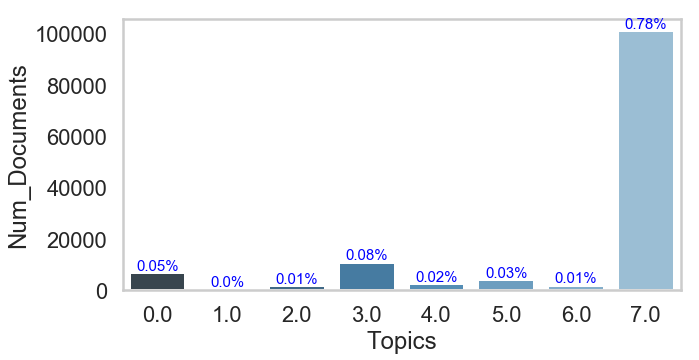

In [39]:
# Number of Documents for Each Topic
temp=Topic_df.groupby('Dominant_Topic').agg('count').reset_index()
topic_counts=temp[['Dominant_Topic','screen_name']]

# Percentage of Documents for Each Topic
topic_counts['topic_contribution'] = round(topic_counts['screen_name']/topic_counts['screen_name'].sum(), 4)
topic_counts.columns=['Dominant_Topic', 'Num_Documents', 'Perc_Documents']

#Plot the topics
sns.set_style("whitegrid", {'axes.grid' : False})
plt.figure(figsize=(10,5))
ax = sns.barplot(data=topic_counts, x= "Dominant_Topic", y = "Num_Documents",  palette=("Blues_d"))
ax.set(xlabel = 'Topics')
sns.set_context("poster")
labels = [str(round(i,2))+'%' for i in topic_counts['Perc_Documents']]
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            fontsize=15, color='blue', ha='center', va='bottom')

plt.show()

## Visualize the word distribution

In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      43.663483  1        1      -0.270328  0.041407
0      16.288910  1        2      -0.231130  0.028563
3      12.058339  1        3       0.179811  0.199544
4      11.038800  1        4      -0.209005 -0.036879
5      5.201863   1        5       0.148022  0.248467
2      4.760643   1        6       0.173238 -0.252277
1      3.594927   1        7       0.088010 -0.266924
6      3.393029   1        8       0.121382  0.038099, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
8381   Default  56378.000000  de           56378.000000  30.0000  30.0000
15714  Default  35798.000000  la           35798.000000  29.0000  29.0000
4521   Default  26476.000000  que          26476.000000  28.0000  28.0000
6811   Default  12135.000000  bannon       12135.000000  27.0000  27.0000
5289   Default  22211.000000  en           22211.000000  26.0000  26.0000
7708   Default  19523.000000  follow       19523.000000  25.0000  25.0000
6967   Default  18234.000000  new          18234.000000  24.0000  24.0000
5708   Default  9552.000000   tag          9552.000000   23.0000  23.0000
166    Default  19399.000000  use          19399.000000  22.0000  22.0000
3928   Default  11922.000000  com          11922.000000  21.0000  21.0000
5888   Default  20686.000000  violence     20686.000000  20.0000  20.0000
15909  Default  17307.000000  link         17307.000000  19.0000  19.0000
6642   Default  14928.000000  pa           14928.000000  18.0000  18.0000
8221   Default  12712.000000  pay          12712.000000  17.0000  17.0000
13262  Default  12134.000000  company      12134.000000  16.0000  16.0000
4280   Default  12569.000000  un           12569.000000  15.0000  15.0000
15572  Default  12525.000000  el           12525.000000  14.0000  14.0000
680    Default  12454.000000  le           12454.000000  13.0000  13.0000
10408  Default  11488.000000  trump        11488.000000  12.0000  12.0000
10845  Default  11388.000000  vote         11388.000000  11.0000  11.0000
9452   Default  14814.000000  bio          14814.000000  10.0000  10.0000
2378   Default  6902.000000   och          6902.000000   9.0000   9.0000 
16938  Default  22108.000000  men          22108.000000  8.0000   8.0000 
12503  Default  24378.000000  love         24378.000000  7.0000   7.0000 
17680  Default  9107.000000   campaign     9107.000000   6.0000   6.0000 
12203  Default  6593.000000   www          6593.000000   5.0000   5.0000 
7205   Default  8782.000000   black        8782.000000   4.0000   4.0000 
2793   Default  11726.000000  man          11726.000000  3.0000   3.0000 
16265  Default  24744.000000  day          24744.000000  2.0000   2.0000 
17161  Default  8772.000000   et           8772.000000   1.0000   1.0000 
...        ...           ...  ...                   ...     ...      ... 
18139  Topic8   2540.793213   all          2541.650879   3.3831  -4.5578 
14889  Topic8   2503.695068   per          2504.551025   3.3831  -4.5725 
17633  Topic8   2304.321777   agency       2305.180176   3.3831  -4.6555 
3579   Topic8   2090.401123   dan          2091.256836   3.3830  -4.7529 
15973  Topic8   2081.708496   che          2082.563477   3.3830  -4.7571 
11485  Topic8   1966.362061   yang         1967.217407   3.3830  -4.8141 
9477   Topic8   1763.747803   launch       1764.604858   3.3830  -4.9228 
6730   Topic8   1749.571777   به           1750.426636   3.3830  -4.9309 
3110   Topic8   1669.796021   catch        1670.653198   3.3829  -4.9776 
5558   Topic8   1647.712769   ik           1648.567993   3.3829  -4.9909 
17863  Topic8   1611.231445   totally      1612.088867   3.3829  -5.0133 
6563   Topic8   1600.317749   lol          1601.175049   3.3829  -5.0201 
11746  Topic8   1570.476318   در           1571.331177   3.3829  -5.0389 
3417   Topic8

## Similarity between the documents

In [ ]:
NUM_TOPICS=8
topics = lda_model.get_document_topics(corpus, per_word_topics=True)
doc_topic_matrix = np.zeros((len(data), NUM_TOPICS))

for idx, i in enumerate(topics):
    for j in i[0]:
        doc_topic_matrix[idx, j[0]] = j[1]

cos_sim = doc_topic_matrix.dot(doc_topic_matrix.T)
cos_sim = cos_sim - np.eye(len(data))
I,J = np.where(cos_sim > 0.7)
col = np.column_stack((I,J,cos_sim[I,J]))
with open('similaritygraph.txt', 'w') as f:
    for row in col:
        if row[0] < row[1]:
            f.write('{}\t{}\t{}\n'.format(int(row[0]),int(row[1]),row[2]))

## Community detection through infomap

In [ ]:
#!pip install infomap
!infomap similaritygraph.txt sim_output/ -N 5 --clu

In [ ]:
import pandas as pd
nodes = pd.read_csv('sim_output/similaritygraph.clu', sep=' ', header=None, skiprows=2, names=['id', 'label', 'score'])
edges = pd.read_csv('similaritygraph.txt', sep='\t', header=None, names=['source', 'target', 'weight'])
id_mapping = pd.read_csv('similarity_id_mapping.csv', sep=';')

## Sentiment classification for the communities

If weighted average of the sentiment scores of hashtag and tweets is more than 0.6 then positive, if its below 0.4 then negative else neutal

In [ ]:
from textblob import TextBlob

ht_df = pd.read_csv('ouput.results', sep='\t', index_col='ID')[['Node', 'Label']]
ht_df['Label'] = ht_df.apply(lambda x: 1.0 if x['Label'] == 'pos' else (0.0 if x['Label'] == 'neg' else 0.5), axis=1)

ht_dic = ht_df.set_index('Node').to_dict()['Label']

#Classifier
def get_hashtag_polarity(tweet, hashtag_list):
    polarity = 0.0
    count = 0.0
    tweet_polarity = TextBlob(tweet).sentiment[0]
    for ht in hashtag_list:
        if ht in ht_dic:
            polarity += ht_dic[ht]
            count += 1.0
    if count > 0:
        polarity = polarity/count
        result_polarity = (tweet_polarity+polarity)/2.0
    else:
        result_polarity = tweet_polarity
    return [polarity, result_polarity, 'pos' if result_polarity > 0.6 else ('neg' if result_polarity < 0.4 else 'neutral')]
     

Thus we see that most of the sentiment scores above are negative which is desired as most tweets are convey negative emotions.

In [ ]:
id_mapping['sentiment'] = id_mapping.apply(lambda x: get_hashtag_polarity(x['lemma_filter'], x['hashtags_list']), axis=1)
nodesdf = pd.merge(nodes, id_mapping[['index', 'sentiment']], left_on=['id'], right_on=['index'], how='inner')
nodesdf['sentiment'] = nodesdf.apply(lambda x: x['sentiment'][2], axis=1)
nodesdf.drop('index', axis=1).to_csv('similarity_graph_nodes.csv', sep=',', header=True, index=None)
edges.to_csv('similarity_graph_edges.csv', sep=',', header=True, index=None)
nodesdf.head(5)
edges.head(5)
id_mapping

## Conclusion

In conclusion we have tried different topic models to get better topics, performed advanced EDA, detected communities based on topic networks and calculated sentiments of each community with advanced state of the art techniques like LBP. Intutively this analysis would help in grouping similar minded people together and knowing their emotion for #MeToo, thereby enabling targeted spread of awareness that could educate them without hurting their social beliefs.